# Momentum Strategy Backtest

This notebook demonstrates the new backtest workflow:
- Configure strategy with a simple Python dict
- Run walk-forward validation
- Auto-generate comprehensive report
- Interactive exploration of results

In [1]:
# Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Reload modules to pick up changes
import importlib
import signals.momentum
importlib.reload(signals.momentum)

from core.backtest_engine import run_walk_forward
from signals.momentum import MomentumSignal, MomentumSignalV2
from analysis.report import BacktestReport

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Data

In [2]:
# Load SPX data
df = pd.read_csv('../Dataset/spx_full_1990_2025.csv', index_col=0, parse_dates=True)
df = df.sort_index()

print(f"Data loaded: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Total rows: {len(df):,}")
print(f"\nColumns: {df.columns.tolist()}")

# Display summary
df.tail()

Data loaded: 1990-01-02 to 2025-11-18
Total rows: 6,012

Columns: ['Open', 'High', 'Low', 'Close', 'Volume']


,Open,High,Low,Close,Volume
Date,,,,,
2025-11-12,6867.77,6869.91,6829.62,6850.92,NaN
2025-11-13,6826.47,6828.05,6724.72,6737.49,NaN
2025-11-14,6672.14,6774.31,6646.87,6734.11,NaN
2025-11-17,6713.61,6754.50,6638.90,6672.41,NaN
2025-11-18,6636.43,6666.63,6574.13,6651.29,NaN


## 2. Configure Backtest

All parameters in one place - easy to see and modify!

In [3]:
# Configuration dict - modify these parameters as needed
config = {
    'signal_factory': lambda: MomentumSignalV2(lookback=20, entry_threshold=0.2, exit_threshold=-0.01),
    'df': df,
    'train_size': int(len(df) * 0.6),  # 60% training window
    'test_size': int(len(df) * 0.2),   # 20% testing window
    'lookback': 250,                    # History for indicators
    'initial_cash': 100_000,
    'transaction_cost': 3.0,            # 3 bps per trade
    'stop_loss_pct': 0.1,              # 10% stop loss           # 100% invested
    'save_dir': '../logs/momentum_v2',  # Output directory
}


stop_loss_pct=0.10,  # 10% stop loss
save_dir='logs/test_diagnostics',

print("Backtest Configuration:")
print("=" * 50)
for k, v in config.items():
    if k not in ['signal_factory', 'df']:
        print(f"{k:20s}: {v}")

Backtest Configuration:
train_size          : 3607
test_size           : 1202
lookback            : 250
initial_cash        : 100000
transaction_cost    : 3.0
stop_loss_pct       : 0.1
save_dir            : ../logs/momentum_v2


## 3. Run Backtest

This will:
- Run anchored walk-forward validation
- Save results to `logs/momentum_v1/`
- Auto-generate HTML report
- Print summary to console

In [4]:
# Run backtest
results = run_walk_forward(**config)

HTML report saved to: ../logs/momentum_v2/report.html

                BACKTEST REPORT
Period:           2004-04-21 to 2025-11-17
Total Return:     -12.40%
CAGR:             -1.38%
Sharpe Ratio:     +0.461
Sortino Ratio:    +0.522
Calmar Ratio:     -0.016
Max Drawdown:     -87.82%

------------------------------------------------------------
                  TRADE STATISTICS
------------------------------------------------------------
Number of Trades: 46
Win Rate:         4.3%
Profit Factor:    0.74
Avg Win:          +138.81%
Avg Loss:         -8.52%
Largest Win:      +174.57%
Largest Loss:     -29.70%

------------------------------------------------------------
                REGIME ANALYSIS
------------------------------------------------------------
Market Correlation: +0.903
Avg Return (Up Days):   +3.2478%
Avg Return (Down Days): -4.2460%

Diagnostics report saved to: ../logs/momentum_v2/diagnostics.txt

📊 Diagnostics saved to: ../logs/momentum_v2/diagnostics.txt


## 4. Analyze Results

The results dict contains:
- `stitched_equity`: Portfolio value over time
- `combined_returns`: Daily strategy returns
- `trades`: All trades from all folds
- `folds`: Summary of each walk-forward fold
- `df`: Original market data

In [5]:
# Create report object for interactive analysis
report = BacktestReport(results)

# Print summary (already shown above, but can call again)
report.summary()


                BACKTEST REPORT
Period:           2004-04-21 to 2025-11-17
Total Return:     -12.40%
CAGR:             -1.38%
Sharpe Ratio:     +0.461
Sortino Ratio:    +0.522
Calmar Ratio:     -0.016
Max Drawdown:     -87.82%

------------------------------------------------------------
                  TRADE STATISTICS
------------------------------------------------------------
Number of Trades: 46
Win Rate:         4.3%
Profit Factor:    0.74
Avg Win:          +138.81%
Avg Loss:         -8.52%
Largest Win:      +174.57%
Largest Loss:     -29.70%

------------------------------------------------------------
                REGIME ANALYSIS
------------------------------------------------------------
Market Correlation: +0.903
Avg Return (Up Days):   +3.2478%
Avg Return (Down Days): -4.2460%



## 5. Interactive Visualizations

In [6]:
# Plot equity curve (if plotly is installed)
fig = report.plot_equity()
if fig:
    fig.show()
else:
    # Fallback to matplotlib
    plt.figure(figsize=(12, 6))
    plt.plot(results['stitched_equity'].index, results['stitched_equity'].values)
    plt.title('Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True, alpha=0.3)
    plt.show()

## 6. Investigate Worst Days

In [7]:
# Get worst 10 days with market context
worst_days = report.worst_days(10)
display(worst_days)

,Date,strategy_return,market_return,market_close
0,2008-12-11,-0.319086,-0.319086,852.3
1,2008-01-12,-0.297046,-0.297046,816.2
2,2008-11-11,-0.280224,-0.280224,899.0
3,2008-10-10,-0.270130,-0.270130,899.2
4,2020-12-03,-0.265964,-0.265964,2480.6
5,2008-09-10,-0.256921,-0.256921,909.9
6,2009-10-02,-0.245255,-0.245255,827.2
7,2009-03-02,-0.244050,-0.244050,838.5
8,2009-11-02,-0.243672,-0.243672,833.7
9,2009-04-02,-0.243386,-0.243386,832.2


## 7. Investigate Worst Trades

In [8]:
# Get worst 10 trades
worst_trades = report.worst_trades(10)
display(worst_trades)

,entry_date,exit_date,side,entry_price,exit_price,pnl_pct,exit_reason,fold
2,2008-01-10,2008-01-12,long,1161.1,816.2,-0.297046,stop_loss,1
22,2008-10-03,2008-10-10,long,1273.4,899.2,-0.293859,stop_loss,1
14,2008-05-03,2008-05-11,long,1333.7,952.8,-0.285596,stop_loss,1
32,2009-05-05,2009-06-03,long,903.8,683.4,-0.243859,stop_loss,1
36,2009-07-07,2009-09-03,long,881.0,676.5,-0.232123,stop_loss,1
24,2008-10-12,2009-02-03,long,899.2,700.8,-0.220641,stop_loss,1
16,2008-06-02,2008-06-10,long,1326.5,1056.9,-0.203242,stop_loss,1
4,2008-02-04,2008-02-10,long,1367.5,1114.3,-0.185155,stop_loss,1
42,2009-11-05,2009-12-03,long,909.2,750.7,-0.174329,stop_loss,1
12,2008-04-11,2008-04-12,long,1005.8,845.2,-0.159674,stop_loss,1


## 8. Custom Analysis

Now you have full access to all the data for custom analysis!

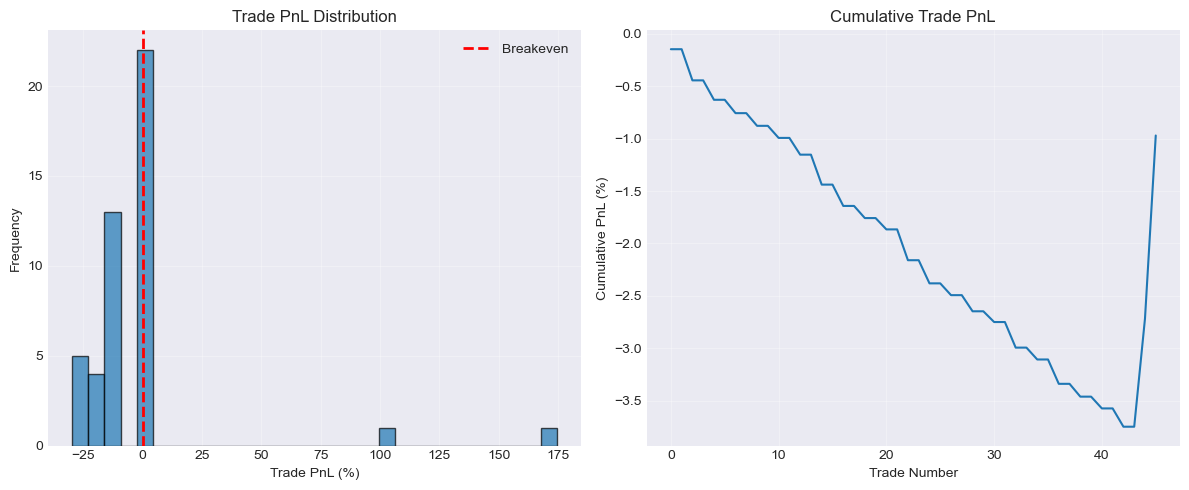

In [9]:
# Trade PnL distribution
if not results['trades'].empty:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(results['trades']['pnl_pct'] * 100, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Breakeven')
    plt.xlabel('Trade PnL (%)')
    plt.ylabel('Frequency')
    plt.title('Trade PnL Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    cumulative_pnl = results['trades']['pnl_pct'].cumsum()
    plt.plot(cumulative_pnl.values)
    plt.xlabel('Trade Number')
    plt.ylabel('Cumulative PnL (%)')
    plt.title('Cumulative Trade PnL')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No trades to display")

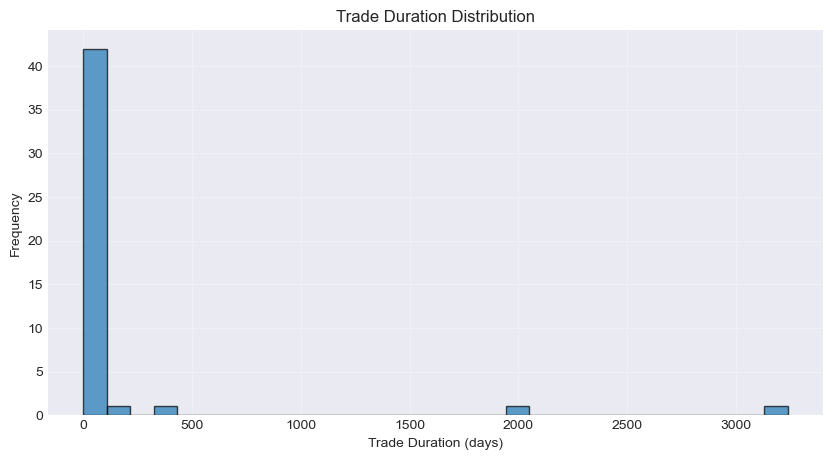

Average trade duration: 131.6 days
Median trade duration: 1.0 days


In [10]:
# Analyze trade duration
if not results['trades'].empty:
    trades = results['trades'].copy()
    trades['entry_date'] = pd.to_datetime(trades['entry_date'])
    trades['exit_date'] = pd.to_datetime(trades['exit_date'])
    trades['duration_days'] = (trades['exit_date'] - trades['entry_date']).dt.days
    
    plt.figure(figsize=(10, 5))
    plt.hist(trades['duration_days'], bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Trade Duration (days)')
    plt.ylabel('Frequency')
    plt.title('Trade Duration Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Average trade duration: {trades['duration_days'].mean():.1f} days")
    print(f"Median trade duration: {trades['duration_days'].median():.1f} days")

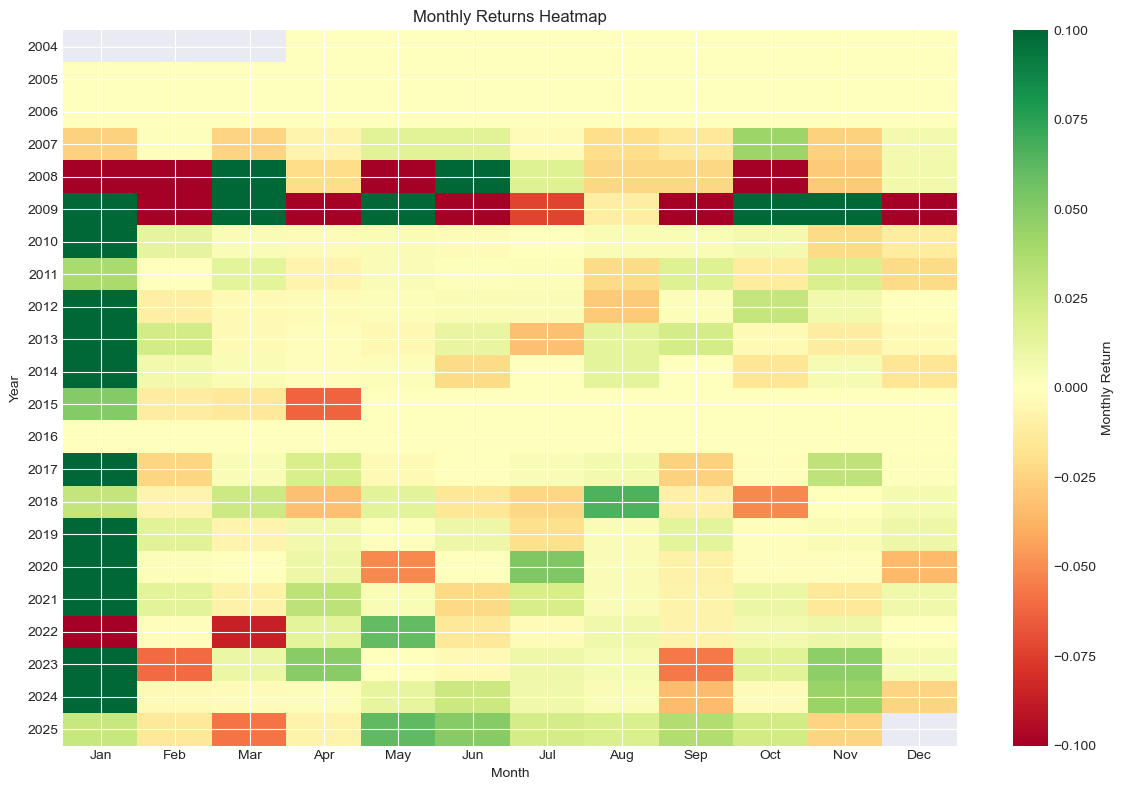

In [11]:
# Monthly returns heatmap
returns_series = results['combined_returns'].copy()
returns_series.index = pd.to_datetime(returns_series.index)

monthly = returns_series.resample('ME').apply(lambda x: (1 + x).prod() - 1)
monthly_df = monthly.to_frame('return')
monthly_df['year'] = monthly_df.index.year
monthly_df['month'] = monthly_df.index.month

pivot = monthly_df.pivot(index='year', columns='month', values='return')
pivot.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 8))
plt.imshow(pivot.values, cmap='RdYlGn', aspect='auto', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Monthly Return')
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.title('Monthly Returns Heatmap')
plt.ylabel('Year')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

## 9. Walk-Forward Fold Analysis

,fold,start,end,fold_return_pct,sharpe,max_drawdown,n_trades
0,1,2004-04-21,2015-04-09,-0.686365,0.302314,-0.878223,45
1,2,2015-04-11,2025-11-17,1.792967,0.668070,-0.329966,1


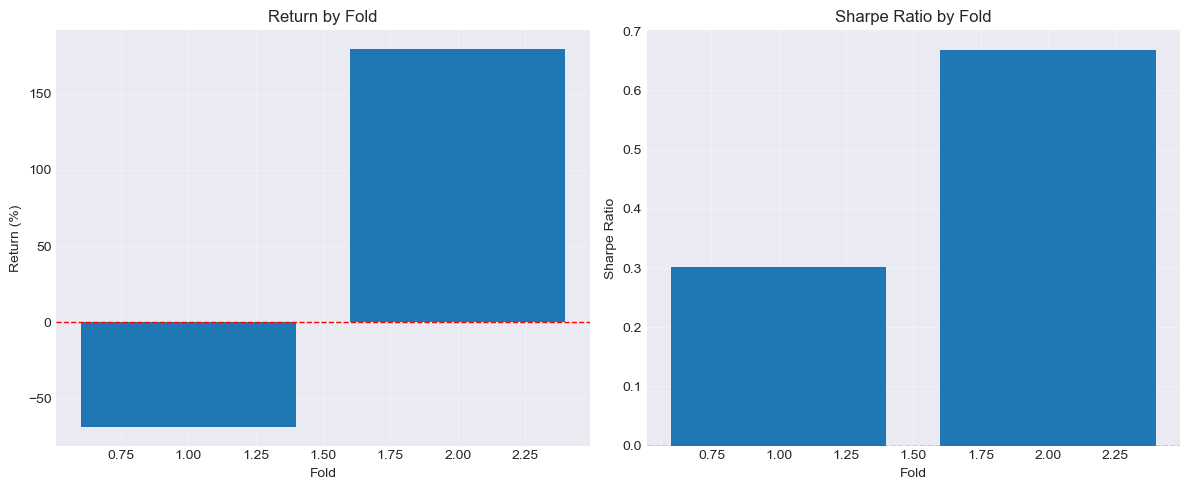

In [12]:
# Display fold summaries
folds_df = pd.DataFrame(results['folds'])
display(folds_df)

# Plot fold performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(folds_df['fold'], folds_df['fold_return_pct'] * 100)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Fold')
plt.ylabel('Return (%)')
plt.title('Return by Fold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(folds_df['fold'], folds_df['sharpe'])
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Fold')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio by Fold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Model Diagnostics

Deep dive into signal quality, execution, and regime performance

In [13]:
from analysis.diagnostics import ModelDiagnostics

# Create diagnostics object
diag = ModelDiagnostics(results)

# Print comprehensive report
print(diag.summary_report())

MODEL DIAGNOSTICS REPORT

1. SIGNAL QUALITY
----------------------------------------------------------------------
Signal Accuracy:           15.6%
Theoretical Sharpe:        0.325
Position Changes/Year:     140.9

2. EXECUTION LEAKAGE
----------------------------------------------------------------------
Theoretical Sharpe:        +0.325
Actual Sharpe:             +0.461
Leakage:                   -0.136 (-41.7%)

3. REGIME BREAKDOWN
----------------------------------------------------------------------
Bull Market    : Sharpe +1.285 | Return +10790981.18% | Days 4,478
Bear Market    : Sharpe -2.031 | Return -100.00% | Days 1,534
High Vol       : Sharpe +0.519 | Return -28.17% | Days 1,798
Low Vol        : Sharpe -0.388 | Return +21.95% | Days 4,214

4. TRADE ANATOMY
----------------------------------------------------------------------
Total Trades:              46
Win Rate:                  4.3%
Avg Hold (Wins):           2593.5 days
Avg Hold (Losses):         19.7 days
Long Win Rat

### 10.1 Signal Quality Analysis

Does the raw signal have predictive power before execution?

In [14]:
# Signal quality metrics
signal_quality = diag.signal_quality_report()

print("Signal Quality Metrics:")
print("=" * 50)
for key, value in signal_quality.items():
    if isinstance(value, float):
        print(f"{key:30s}: {value:.4f}")
    else:
        print(f"{key:30s}: {value}")

Signal Quality Metrics:
signal_accuracy_pct           : 0.1557
signal_sharpe_theoretical     : 0.3255
avg_position                  : 0.6040
position_changes_per_year     : 140.9222


### 10.2 Regime Breakdown

How does the strategy perform in different market conditions?


Regime Performance:


,Days,Sharpe,Total Return,Max Drawdown
regime,,,,
Bull Market,4478,1.285080,107909.811798,-0.206660
Bear Market,1534,-2.030610,-0.999992,-0.999993
High Vol,1798,0.519097,-0.281692,-0.878223
Low Vol,4214,-0.387577,0.219495,-0.221417


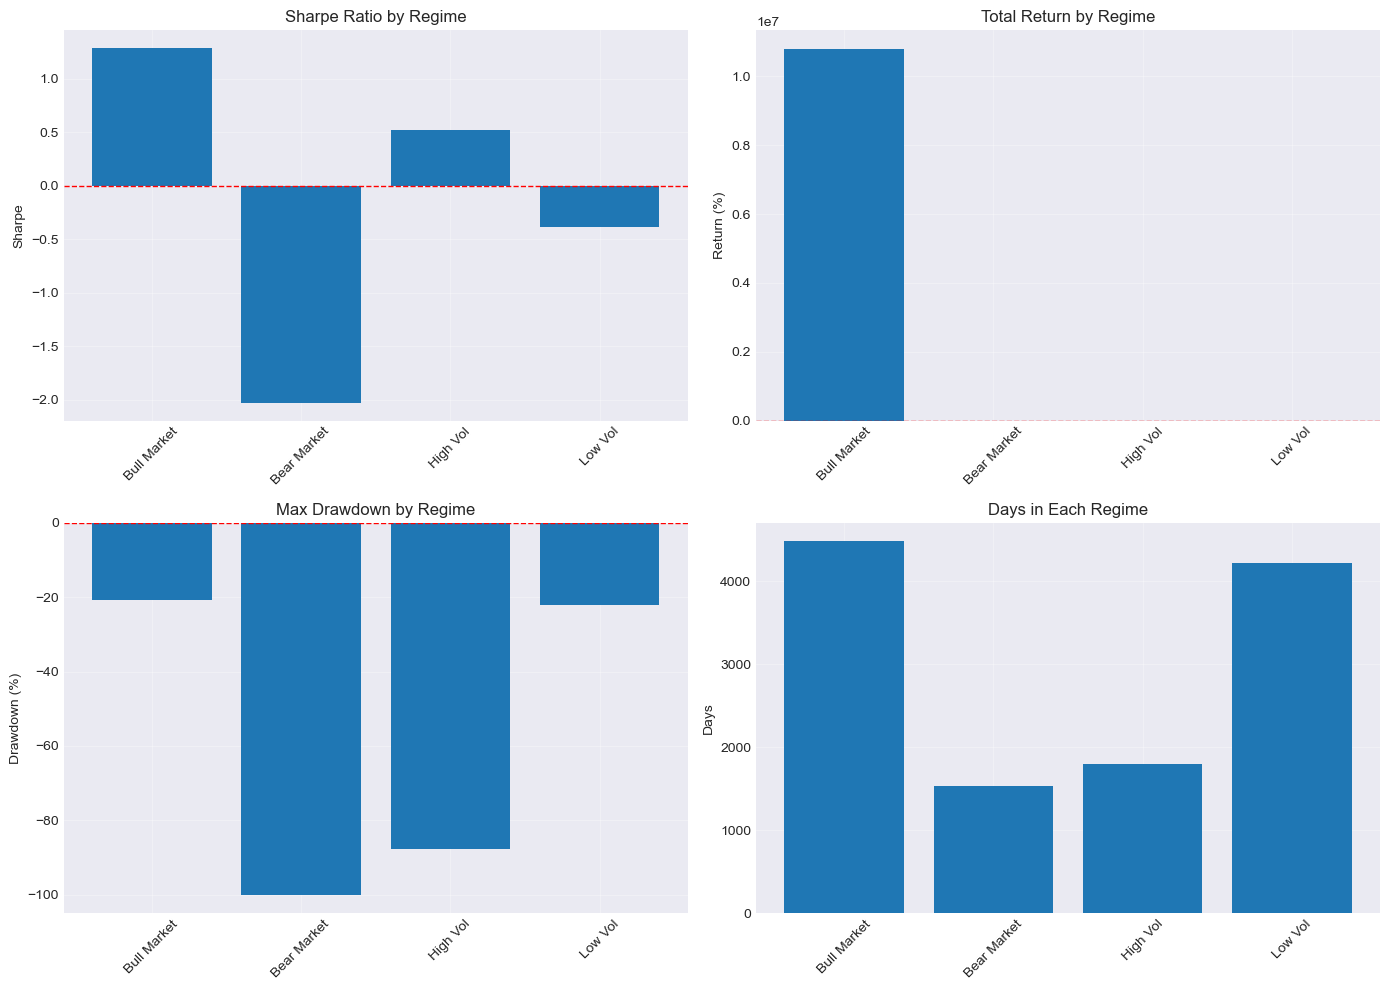

In [17]:
# Regime performance breakdown
regime_stats = diag.regime_breakdown()

# Check if we got data
if not regime_stats.empty and 'regime' in regime_stats.columns:
    # Set regime as index for easier access
    regime_df = regime_stats.set_index('regime')
    
    # Rename columns for display
    regime_df = regime_df.rename(columns={
        'n_days': 'Days',
        'total_return': 'Total Return',
        'sharpe': 'Sharpe',
        'max_drawdown': 'Max Drawdown'
    })
    
    print("\nRegime Performance:")
    print("=" * 50)
    display(regime_df)
    
    # Visualize regime performance
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Sharpe by regime
    axes[0, 0].bar(regime_df.index, regime_df['Sharpe'])
    axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_title('Sharpe Ratio by Regime')
    axes[0, 0].set_ylabel('Sharpe')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Total return by regime
    axes[0, 1].bar(regime_df.index, regime_df['Total Return'] * 100)
    axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[0, 1].set_title('Total Return by Regime')
    axes[0, 1].set_ylabel('Return (%)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Max drawdown by regime
    axes[1, 0].bar(regime_df.index, regime_df['Max Drawdown'] * 100)
    axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[1, 0].set_title('Max Drawdown by Regime')
    axes[1, 0].set_ylabel('Drawdown (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Days in each regime
    axes[1, 1].bar(regime_df.index, regime_df['Days'])
    axes[1, 1].set_title('Days in Each Regime')
    axes[1, 1].set_ylabel('Days')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No regime data available - signal columns may not be preserved")

### 10.3 Trade Anatomy

Detailed analysis of trade characteristics and exit reasons


Trade Anatomy:
Total Trades: 46
Win Rate: 4.3%
Average Hold Period: 131.6 days
  Winners: 2593.5 days
  Losers: 19.7 days

Exit Reasons:
  stop_loss           :  22 ( 47.8%)

Long/Short Breakdown:
  Long trades: 24
  Long win rate: 8.3%
  Short trades: 22
  Short win rate: 0.0%


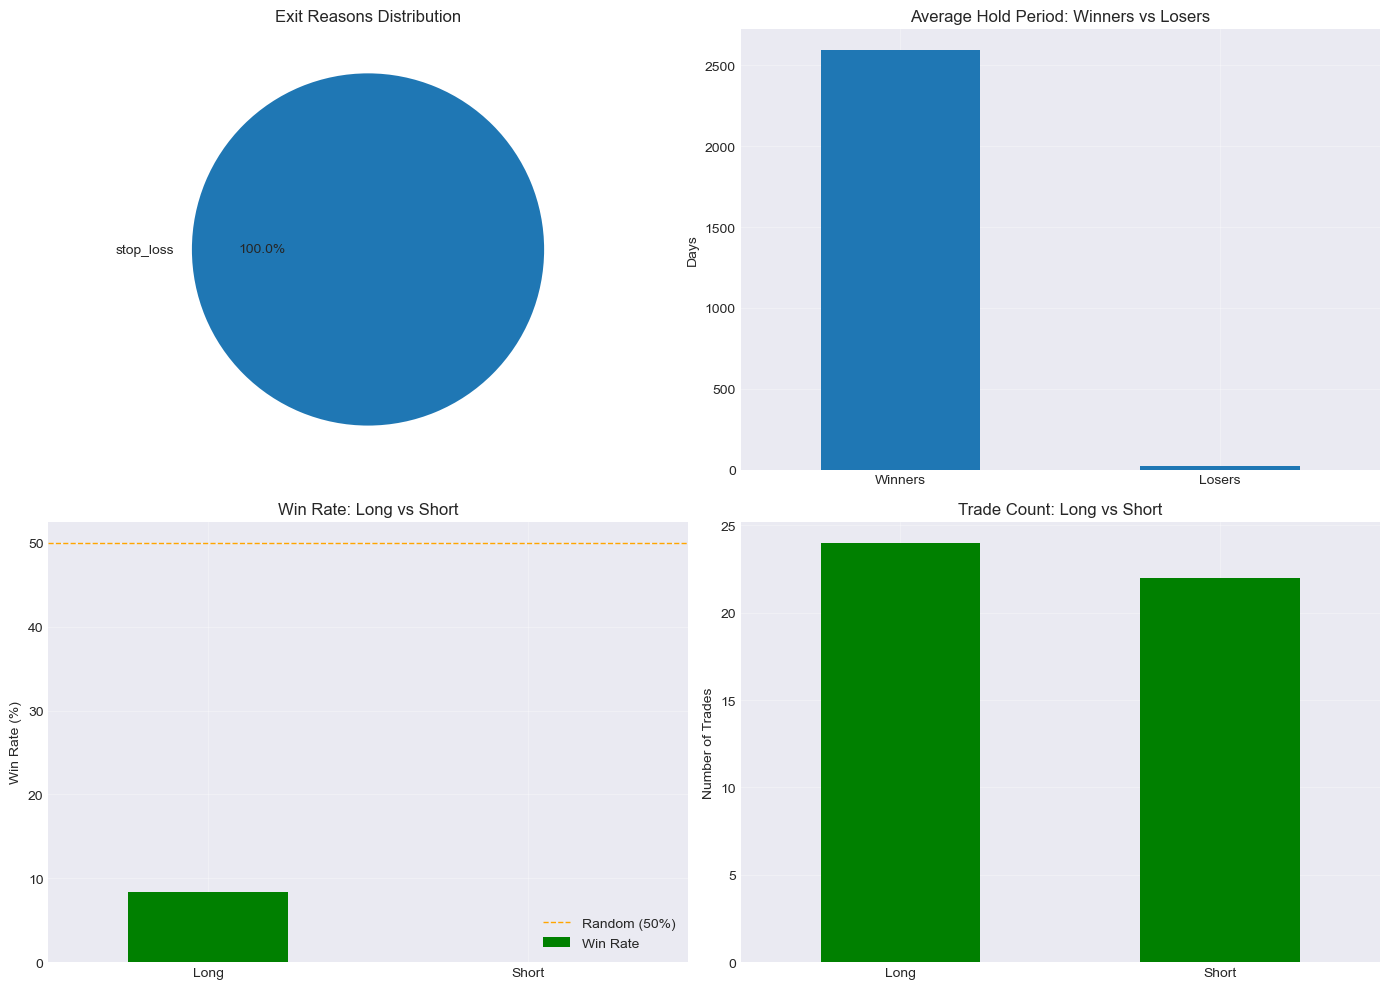

In [20]:
# Trade anatomy analysis
trade_anatomy = diag.trade_anatomy()

# Calculate additional metrics
trades_df = results['trades'].copy()
long_trades = len(trades_df[trades_df['side'] == 'long']) if 'side' in trades_df else 0
short_trades = len(trades_df[trades_df['side'] == 'short']) if 'side' in trades_df else 0
avg_hold_period = (trade_anatomy['avg_hold_days_wins'] * trade_anatomy['win_rate'] + 
                   trade_anatomy['avg_hold_days_losses'] * (1 - trade_anatomy['win_rate']))

print("\nTrade Anatomy:")
print("=" * 50)
print(f"Total Trades: {trade_anatomy['total_trades']}")
print(f"Win Rate: {trade_anatomy['win_rate']:.1%}")
print(f"Average Hold Period: {avg_hold_period:.1f} days")
print(f"  Winners: {trade_anatomy['avg_hold_days_wins']:.1f} days")
print(f"  Losers: {trade_anatomy['avg_hold_days_losses']:.1f} days")
print()
print("Exit Reasons:")
for reason, count in trade_anatomy['exit_reasons'].items():
    pct = count / trade_anatomy['total_trades'] * 100
    print(f"  {reason:20s}: {count:3d} ({pct:5.1f}%)")
print()
print("Long/Short Breakdown:")
print(f"  Long trades: {long_trades}")
print(f"  Long win rate: {trade_anatomy['long_win_rate']:.1%}")
print(f"  Short trades: {short_trades}")
print(f"  Short win rate: {trade_anatomy['short_win_rate']:.1%}")

# Visualize trade anatomy
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Exit reasons pie chart
if trade_anatomy['exit_reasons']:
    exit_counts = list(trade_anatomy['exit_reasons'].values())
    exit_labels = list(trade_anatomy['exit_reasons'].keys())
    axes[0, 0].pie(exit_counts, labels=exit_labels, autopct='%1.1f%%')
    axes[0, 0].set_title('Exit Reasons Distribution')
else:
    axes[0, 0].text(0.5, 0.5, 'No exit reasons data', ha='center', va='center')
    axes[0, 0].set_title('Exit Reasons Distribution')

# Hold period comparison
hold_comparison = pd.DataFrame({
    'Winners': [trade_anatomy['avg_hold_days_wins']],
    'Losers': [trade_anatomy['avg_hold_days_losses']]
})
hold_comparison.T.plot(kind='bar', ax=axes[0, 1], legend=False)
axes[0, 1].set_title('Average Hold Period: Winners vs Losers')
axes[0, 1].set_ylabel('Days')
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(True, alpha=0.3)

# Long vs Short win rates
ls_data = pd.DataFrame({
    'Win Rate': [
        trade_anatomy['long_win_rate'] * 100,
        trade_anatomy['short_win_rate'] * 100
    ]
}, index=['Long', 'Short'])
ls_data.plot(kind='bar', ax=axes[1, 0], legend=False, color=['green', 'red'])
axes[1, 0].axhline(50, color='orange', linestyle='--', linewidth=1, label='Random (50%)')
axes[1, 0].set_title('Win Rate: Long vs Short')
axes[1, 0].set_ylabel('Win Rate (%)')
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Trade count: Long vs Short
ls_counts = pd.DataFrame({
    'Count': [long_trades, short_trades]
}, index=['Long', 'Short'])
ls_counts.plot(kind='bar', ax=axes[1, 1], legend=False, color=['green', 'red'])
axes[1, 1].set_title('Trade Count: Long vs Short')
axes[1, 1].set_ylabel('Number of Trades')
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 10.4 Execution Leakage Analysis

How much performance is lost between signal generation and execution?

In [21]:
# Execution leakage analysis
leakage = diag.execution_leakage()

print("\nExecution Leakage Analysis:")
print("=" * 50)
print(f"Theoretical Sharpe (perfect execution): {leakage['theoretical_sharpe']:.4f}")
print(f"Actual Sharpe (with stops/costs):       {leakage['actual_sharpe']:.4f}")
print(f"Execution Leakage:                       {leakage['leakage_pct']:.1f}%")
print()
if leakage['leakage_pct'] > 20:
    print("⚠️  HIGH LEAKAGE: Execution costs/stops significantly hurt performance")
elif leakage['leakage_pct'] > 10:
    print("⚠️  MODERATE LEAKAGE: Some performance lost to execution")
elif leakage['leakage_pct'] < -10:
    print("✅ POSITIVE IMPACT: Risk controls improved risk-adjusted returns")
else:
    print("✅ LOW LEAKAGE: Execution close to theoretical performance")


Execution Leakage Analysis:
Theoretical Sharpe (perfect execution): 0.3255
Actual Sharpe (with stops/costs):       0.4612
Execution Leakage:                       -0.4%

✅ LOW LEAKAGE: Execution close to theoretical performance


### 10.5 Key Takeaways

Actionable insights from diagnostics

In [ ]:
# Generate insights
insights = []

# Check signal quality
signal_q = diag.signal_quality_report()
if 'error' not in signal_q:
    theoretical_sharpe = signal_q.get('signal_sharpe_theoretical', 0)
    if theoretical_sharpe > 0.5:
        insights.append("✅ Signal has strong predictive power (Sharpe > 0.5)")
    elif theoretical_sharpe > 0:
        insights.append("⚠️  Signal has weak edge (0 < Sharpe < 0.5) - needs improvement")
    else:
        insights.append("❌ Signal has negative edge - fundamentally broken")
else:
    insights.append("⚠️  Signal quality could not be measured - Position column not preserved")

# Check regime dependency
regime_stats = diag.regime_breakdown()
if not regime_stats.empty:
    # Set regime as index for easier access
    regime_dict = regime_stats.set_index('regime')['sharpe'].to_dict()
    bull_sharpe = regime_dict.get('Bull Market', 0)
    bear_sharpe = regime_dict.get('Bear Market', 0)
    
    if bull_sharpe > 0 and bear_sharpe < -1:
        insights.append("⚠️  Strategy ONLY works in bull markets - highly regime-dependent")
    elif bear_sharpe > 0:
        insights.append("✅ Strategy works in both bull AND bear markets")

# Check trade anatomy
trade_anat = diag.trade_anatomy()
if 'error' not in trade_anat:
    if trade_anat['win_rate'] < 0.2:
        insights.append(f"⚠️  Very low win rate ({trade_anat['win_rate']:.1%}) - relies on few big winners")
    
    # Count short trades
    trades_df = results['trades']
    short_trades = len(trades_df[trades_df['side'] == 'short']) if 'side' in trades_df else 0
    if trade_anat['short_win_rate'] == 0 and short_trades > 5:
        insights.append("❌ Short trades have 0% win rate - consider long-only")

# Check execution
leak = diag.execution_leakage()
if leak['leakage_pct'] > 20:
    insights.append("⚠️  High execution leakage - stops may be too tight")

print("\n🔍 KEY INSIGHTS:")
print("=" * 50)
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")
    
print("\n📋 NEXT STEPS:")
if any("❌" in ins for ins in insights):
    print("1. Fix fundamental signal issues before optimization")
    print("2. Consider alternative signal approaches")
elif any("⚠️" in ins for ins in insights):
    print("1. Address warnings above")
    print("2. Test parameter variations")
    print("3. Ready for careful optimization")
else:
    print("1. Signal looks good - ready for optimization")
    print("2. Focus on parameter tuning and risk management")

## 11. Next Steps

Try modifying the configuration above:
- Change `lookback` and `threshold` parameters in MomentumSignal
- Adjust `stop_loss_pct` to see impact on risk management
- Try different transaction costs
- Experiment with different train/test splits

For other signals:
```python
from signals.mean_reversion import MeanReversionSignal
from signals.ensemble import EnsembleSignalNew

# Mean reversion
config['signal_factory'] = lambda: MeanReversionSignal(window=20, entry_z=2.0)

# Ensemble
config['signal_factory'] = lambda: EnsembleSignalNew()
```